In [1]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
from __future__ import print_function
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import pandas as pd
import math
from matplotlib.colors import ListedColormap
from sklearn import neighbors, datasets, preprocessing
from sklearn.impute import SimpleImputer
from sklearn.model_selection import cross_val_score, KFold
from sklearn.decomposition import PCA
from sklearn import preprocessing
from six.moves.urllib.request import urlretrieve
from sklearn.metrics import confusion_matrix

# Config the matplotlib backend as plotting inline in IPython
%matplotlib inline

/home/nishi/anaconda3/envs/knn/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


### DOWNLOAD DATA

Here we download the **adult** dataset from UCI repository

In [2]:
data_root = './dataset'
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/adult/'

last_percent_reported = None

def download_progress_hook(count, blockSize, totalSize):
    """A hook to report the progress of a download. This is mostly intended for users with
    slow internet connections. Reports every 5% change in download progress.
    """
    global last_percent_reported
    percent = int(count * blockSize * 100 / totalSize)

    if last_percent_reported != percent:
        if percent % 5 == 0:
            sys.stdout.write("%s%%" % percent)
            sys.stdout.flush()
        else:
            sys.stdout.write(".")
            sys.stdout.flush()

        last_percent_reported = percent
        
def maybe_download(filename, force=False):
    """Download a file if not present, and make sure it's the right size."""
    dest_filename = os.path.join(data_root, filename)
    os.makedirs(data_root, exist_ok=True)
    if force or not os.path.exists(dest_filename):
        print('Attempting to download:', filename) 
        filename, _ = urlretrieve(url + filename, dest_filename, reporthook=download_progress_hook)
        print('\nDownload Complete!')
    if os.path.exists(dest_filename):
        print('Found ', dest_filename)
    else:
        raise Exception(
        'Failed to find ' + dest_filename + '. Can you get to it with a browser?')
    return dest_filename

train_filename = maybe_download('adult.data')
test_filename  = maybe_download('adult.test') 

Attempting to download: adult.data
0%....5%....10%....15%....20%....25%....30%....35%....40%....45%....50%....55%....60%....65%....70%....75%....80%....85%....90%....95%....100%
Download Complete!
Found  ./dataset/adult.data
Attempting to download: adult.test
0%....5%....10%....15%....20%....25%....30%....35%....40%....45%....50%....55%....60%....65%....70%....75%....80%....85%....90%....95%....100%
Download Complete!
Found  ./dataset/adult.test


## Processing data

In [3]:
def trimAllValues(df):
    trimStrings = lambda x: x.strip() if type(x) is str else x
    return df.applymap(trimStrings)

Here wee convert the **'?'** from missing values to **np.nan**, and change the income labels from test dataset removing the **'.'** at the end of string

In [4]:
attributes = ['age', 'workclass', 'fnlwgt', 'education', 'education-num',
              'marital-status', 'occupation', 'relationship', 'race', 'sex',
              'capital-gain', 'capital-loss', 'hours-per-week', 'native-country',
              'income']

def read_data(filename):
    dataset = pd.read_csv(filename, header=None, names=attributes)

    dataset = trimAllValues(dataset)
    dataset.drop(labels='education', axis=1, inplace=True)
    dataset.replace('?', np.nan, inplace=True)
    dataset.replace('<=50K.', '<=50K', inplace=True)
    dataset.replace('>50K.', '>50K', inplace=True)
#     dataset.dropna(inplace=True)
    return dataset

train = read_data(train_filename)
test  = read_data(test_filename).loc[1:, :]

In [5]:
discrete_cat   = ['workclass', 'education-num', 'marital-status', 'occupation', 'relationship',
                  'race', 'sex', 'native-country', 'income']
continuous_cat = ['age', 'fnlwgt', 'capital-gain', 'capital-loss', 'hours-per-week']

def split_cat(dataset):
    discrete = dataset.loc[:, discrete_cat].reset_index(drop=True)
    continuous = dataset.loc[:, continuous_cat].reset_index(drop=True)
    return discrete, continuous

train_discrete, train_continuous = split_cat(train)
test_discrete, test_continuous = split_cat(test)

In [6]:
def deal_missing_value(dataset, strategy):
    imp = SimpleImputer(missing_values=np.nan, strategy=strategy)
    dataset.loc[:, :] = imp.fit_transform(dataset.values)
    return dataset

train_discrete = deal_missing_value(train_discrete, 'most_frequent')
test_discrete = deal_missing_value(test_discrete, 'most_frequent')

train_continuous = deal_missing_value(train_continuous, 'mean')
test_continuous = deal_missing_value(test_continuous, 'mean')


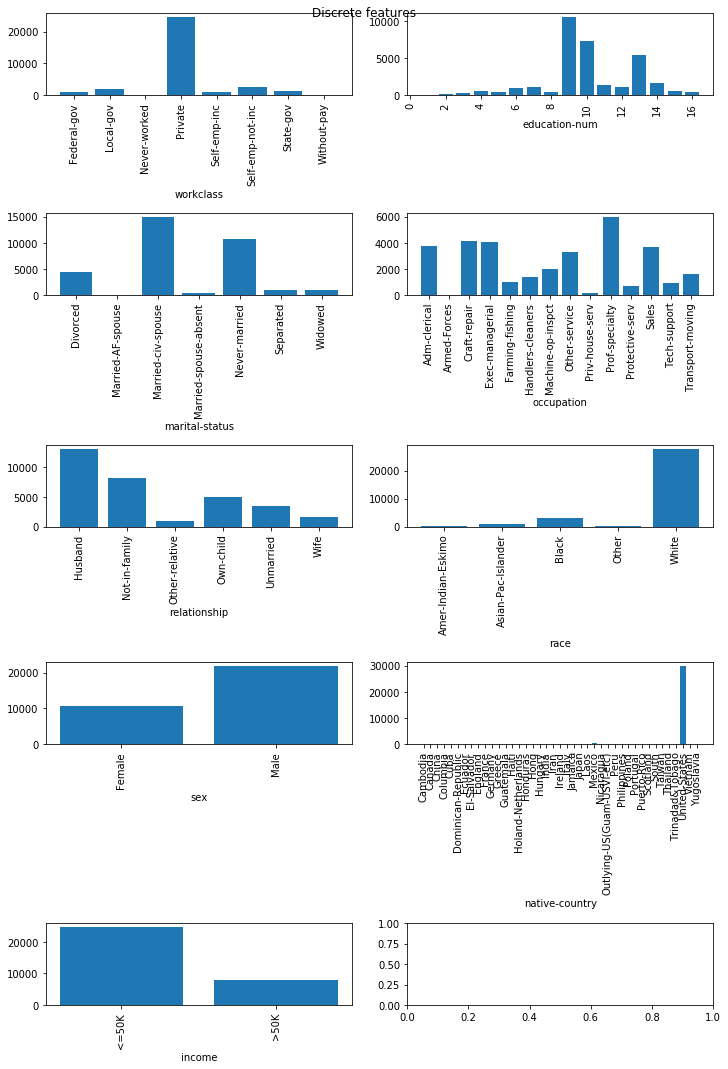

In [7]:
possible_values = []

def plot_discrete(dataset):
    columns = 2
    fig, axs = plt.subplots(nrows=math.ceil(len(discrete_cat)/columns), ncols=columns,
                            figsize=(10,15), constrained_layout=True)
    index = 0

    for attr in discrete_cat:
        grouped = dataset.groupby(attr).size()
        row = int(index / columns)
        col = index % columns
        possible_values.append(grouped.index)
        axs[row][col].bar(grouped.index, grouped.values)
        axs[row][col].set_xlabel(attr)
        for tick in axs[row][col].get_xticklabels():
            tick.set_rotation(90)

        index += 1
    
    fig.suptitle('Discrete features')
    plt.show()

plot_discrete(train_discrete)

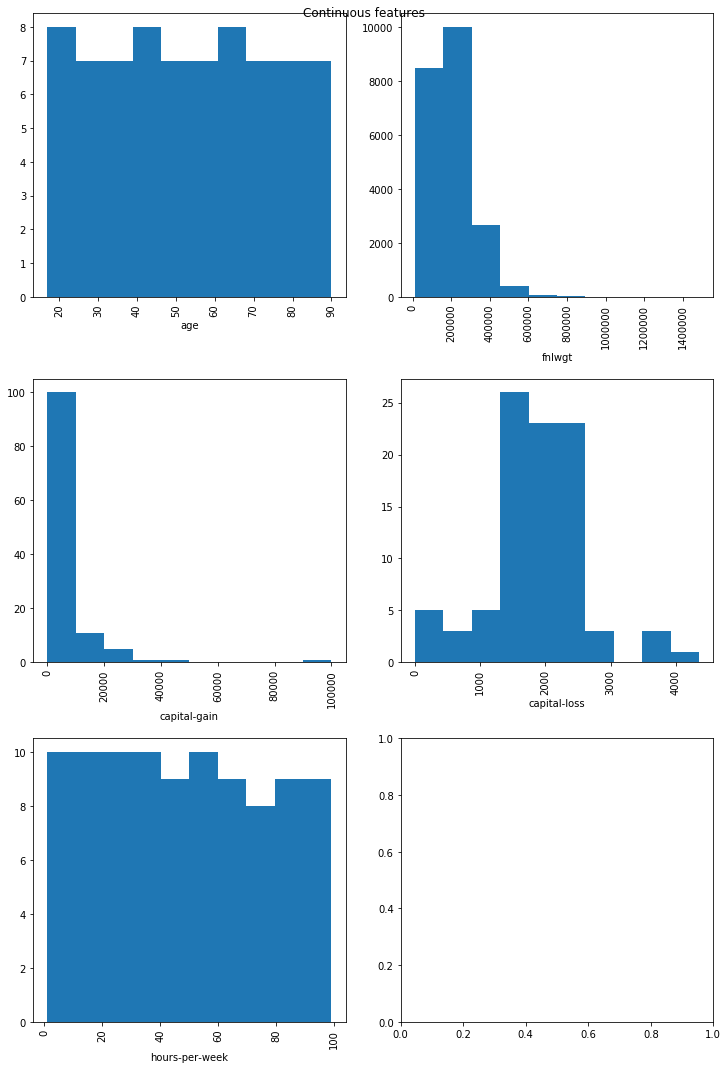

In [8]:
def plot_continuous(dataset):
    columns = 2
    fig, axs = plt.subplots(nrows=math.ceil(len(continuous_cat)/columns), ncols=columns, 
                            figsize=(10, 15), constrained_layout=True)
    index = 0

    for attr in continuous_cat:
        grouped = dataset.groupby(attr).size()
        row = int(index / columns)
        col = index % columns
        axs[row][col].hist(grouped.index)
        axs[row][col].set_xlabel(attr)
        for tick in axs[row][col].get_xticklabels():
            tick.set_rotation(90)
        index += 1
    fig.suptitle('Continuous features')
    plt.show()

plot_continuous(train_continuous)

In [9]:
def encode_discrete(dataset_discrete):
    enc = preprocessing.OrdinalEncoder(categories=possible_values, dtype=np.int64)
    enc.fit(dataset_discrete)
    encoded = pd.DataFrame(enc.transform(dataset_discrete), columns=discrete_cat, dtype=np.int64)

    return encoded

train_discrete_encoded = encode_discrete(train_discrete)
test_discrete_encoded = encode_discrete(test_discrete)

In [10]:
def scale_continuous(dataset_continuous):
    scaler = preprocessing.StandardScaler()
    dataset_continuous.loc[:, :] = scaler.fit_transform(dataset_continuous.values)
    return dataset_continuous

def scale_discrete(dataset_discrete):
    scaler = preprocessing.MinMaxScaler()
    dataset_discrete.loc[:, :] = scaler.fit_transform(dataset_discrete.values)
    return dataset_discrete

train_continuous_scaled = scale_continuous(train_continuous)
test_continuous_scaled = scale_continuous(test_continuous)

train_discrete_encoded_scaled = scale_discrete(train_discrete_encoded)
test_discrete_encoded_scaled = scale_discrete(test_discrete_encoded)

/home/nishi/anaconda3/envs/knn/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)
/home/nishi/anaconda3/envs/knn/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


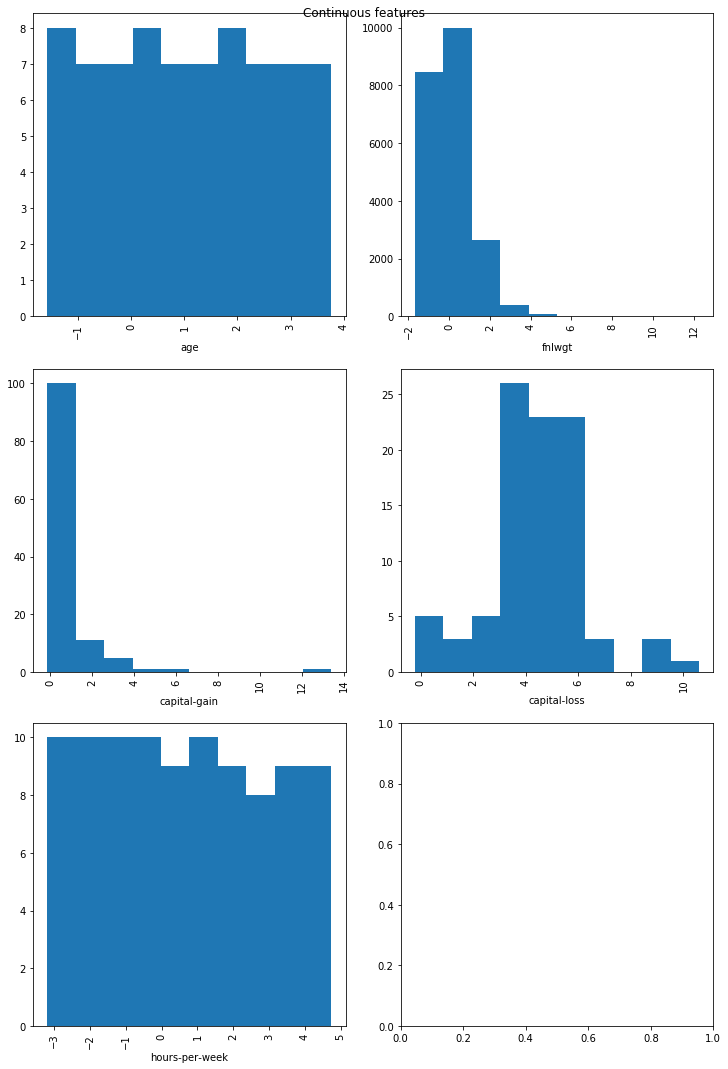

In [11]:
plot_continuous(train_continuous_scaled)

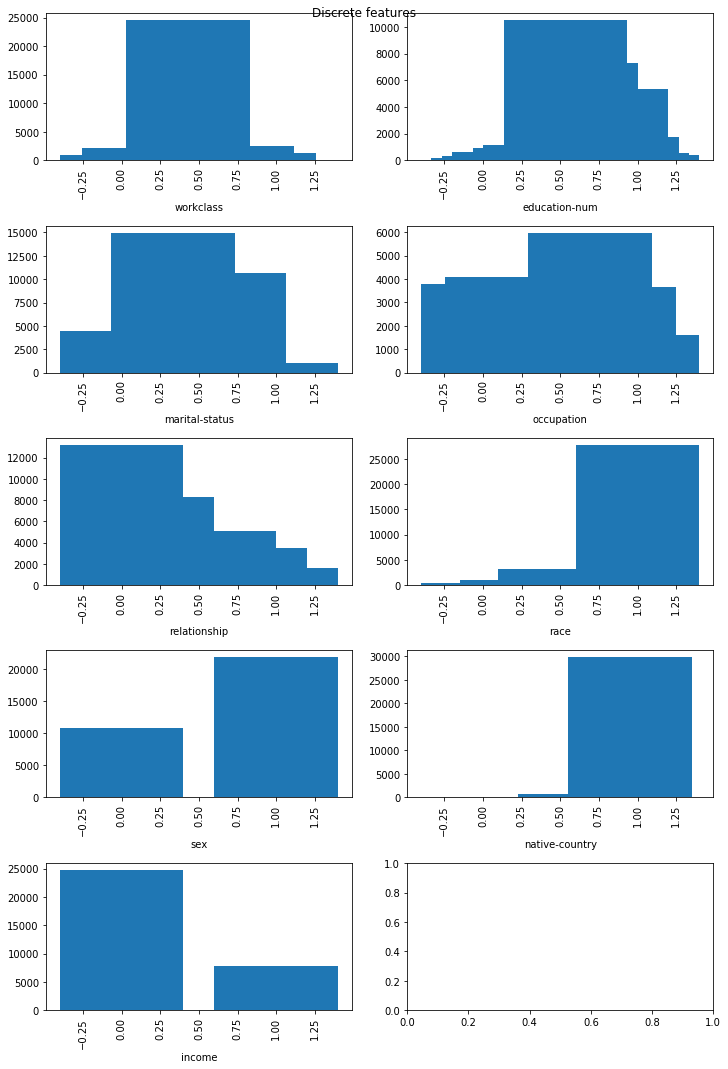

In [12]:
plot_discrete(train_discrete_encoded_scaled)

In [13]:
def join_datasets(continuous, discrete):
    return continuous.join(discrete, sort=True)

def split_label(dataset):
    label = len(dataset.columns)
    X = dataset.iloc[:, :(label - 1)]
    y = dataset.iloc[:, (label - 1)]
    return X, y

X_train, y_train = split_label(join_datasets(train_continuous, train_discrete_encoded))
X_test, y_test = split_label(join_datasets(test_continuous, test_discrete_encoded))

In [14]:
ks = np.arange(1, 100)
acc_mean_manhattan = []
acc_mean_euclidean = []

for k in ks:
    knn_manhattan = neighbors.KNeighborsClassifier(k, p=1)
    knn_euclidean = neighbors.KNeighborsClassifier(k, p=2)
    kfold = KFold(n_splits=5, shuffle=True)
    val_acc_manhattan = np.array([])
    val_acc_euclidean = np.array([])
    for train_index, val_index in kfold.split(X_train, y_train):
        knn_manhattan.fit(X_train.iloc[train_index], y_train.iloc[train_index])
        knn_euclidean.fit(X_train.iloc[train_index], y_train.iloc[train_index])
        val_acc_manhattan = np.append(val_acc_manhattan, knn_manhattan.score(X_train.iloc[val_index], y_train.iloc[val_index]))
        val_acc_euclidean = np.append(val_acc_euclidean, knn_euclidean.score(X_train.iloc[val_index], y_train.iloc[val_index]))
    print(f'k-manhattan={k} - acc: {val_acc_manhattan}')
    print(f'k-euclidean={k} - acc: {val_acc_euclidean}')
    acc_mean_manhattan.append(val_acc_manhattan.mean())
    acc_mean_euclidean.append(val_acc_euclidean.mean())

k-manhattan=1 - acc: [0.79517887 0.79867936 0.80036855 0.80128993 0.80436118]
k-euclidean=1 - acc: [0.78842315 0.79622236 0.79468673 0.79361179 0.80021499]
k-manhattan=2 - acc: [0.8235836  0.82585995 0.8203317  0.82708845 0.82371007]
k-euclidean=2 - acc: [0.82296945 0.81864251 0.81296069 0.81956388 0.8215602 ]
k-manhattan=3 - acc: [0.82051282 0.81956388 0.81910319 0.82478501 0.81833538]
k-euclidean=3 - acc: [0.81437126 0.8088145  0.81664619 0.814957   0.81311425]
k-manhattan=4 - acc: [0.8298787  0.83154177 0.82478501 0.82739558 0.83538084]
k-euclidean=4 - acc: [0.81959159 0.82263514 0.82125307 0.82263514 0.82678133]
k-manhattan=5 - acc: [0.82511899 0.83476658 0.83277027 0.82493857 0.83062039]
k-euclidean=5 - acc: [0.82189467 0.82386364 0.82294226 0.81879607 0.81802826]
k-manhattan=6 - acc: [0.83279595 0.83722359 0.82724201 0.84259828 0.83599509]
k-euclidean=6 - acc: [0.82542607 0.82954545 0.82125307 0.83246314 0.83077396]
k-manhattan=7 - acc: [0.83079994 0.82724201 0.83246314 0.8375307

k-manhattan=53 - acc: [0.83939813 0.83983415 0.83737715 0.84275184 0.83891278]
k-euclidean=53 - acc: [0.82895747 0.8264742  0.83046683 0.83092752 0.83046683]
k-manhattan=54 - acc: [0.83801628 0.84106265 0.84075553 0.83630221 0.83952703]
k-euclidean=54 - acc: [0.82588669 0.83015971 0.82724201 0.82877764 0.83108108]
k-manhattan=55 - acc: [0.83279595 0.84029484 0.84367322 0.84367322 0.83707002]
k-euclidean=55 - acc: [0.82527253 0.82662776 0.83568796 0.83277027 0.82678133]
k-manhattan=56 - acc: [0.84170121 0.84244472 0.84259828 0.83015971 0.83829853]
k-euclidean=56 - acc: [0.83187471 0.83445946 0.83169533 0.82109951 0.83046683]
k-manhattan=57 - acc: [0.83909105 0.84428747 0.84152334 0.8392199  0.83338452]
k-euclidean=57 - acc: [0.82926455 0.83323096 0.83261671 0.82678133 0.81802826]
k-manhattan=58 - acc: [0.84016582 0.83722359 0.83998771 0.83323096 0.83875921]
k-euclidean=58 - acc: [0.83049286 0.82570639 0.82877764 0.82662776 0.82985258]
k-manhattan=59 - acc: [0.8412406  0.8289312  0.84367

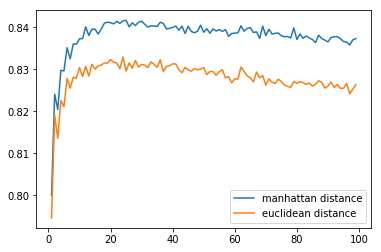

In [15]:
fig, ax = plt.subplots()
ax.plot(ks, acc_mean_manhattan, label='manhattan distance')
ax.plot(ks, acc_mean_euclidean, label='euclidean distance')

ax.legend()
plt.show()

In [16]:
def get_max_k(res, ks):
    index = np.argmax(res)
    return ks[index]

k_manhattan = get_max_k(acc_mean_manhattan, ks)
k_euclidean = get_max_k(acc_mean_euclidean, ks)

print(k_manhattan)
print(k_euclidean)

knn_manhattan = neighbors.KNeighborsClassifier(k_manhattan, p=1)
knn_euclidean = neighbors.KNeighborsClassifier(k_euclidean, p=2)
knn_manhattan.fit(X_train, y_train)
knn_euclidean.fit(X_train, y_train)

25
24


KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=24, p=2,
           weights='uniform')

In [17]:
print(f'manhattan score: {knn_manhattan.score(X_test, y_test)}')
print(f'euclidean score: {knn_euclidean.score(X_test, y_test)}')

manhattan score: 0.840366070880167
euclidean score: 0.8304158221239482


Confusion matrix, without normalization
[[11559   876]
 [ 1723  2123]]
Normalized confusion matrix
[[0.93 0.07]
 [0.45 0.55]]


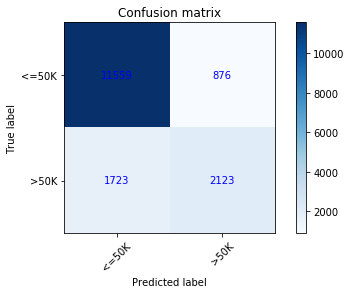

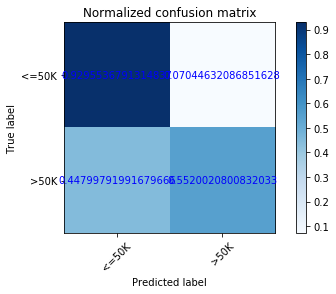

In [46]:
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(2)
    plt.xticks(tick_marks, ['<=50K', '>50K'], rotation=45)
    plt.yticks(tick_marks, ['<=50K', '>50K'])
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    for i in range(2):
        for j in range(2):
            text = plt.text(j, i, cm[i, j], ha='center', va='center', color='b')
    

# Run classifier to predict labels for test set
y_pred = knn_manhattan.predict(X_test)

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)
print('Confusion matrix, without normalization')
print(cm)
plt.figure()
plot_confusion_matrix(cm)

# Normalize the confusion matrix by row (i.e by the number of samples
# in each class)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
print('Normalized confusion matrix')
print(cm_normalized)
plt.figure()
plot_confusion_matrix(cm_normalized, title='Normalized confusion matrix')

plt.show()